In [1]:
import os

import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
from stable_baselines3 import DQN
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.evaluation import evaluate_policy

In [2]:
### Create a callback to store episode rewards ###

class EpisodeRewardTracker(BaseCallback):
    def __init__(self, episode_print_interval, verbose=0):
        super().__init__(verbose)
        self.episode_rewards = []
        self.current_episode_reward = 0  # Track reward for the current episode
        self.episode_print_interval = episode_print_interval
        self.total_steps_completed = 0

    def _on_step(self) -> bool:
        self.current_episode_reward += int(self.locals['rewards'][0] ) # Accumulate step reward
        if self.locals['dones'][0]:  # If the episode is done
            self.episode_rewards.append(self.current_episode_reward)
            self.total_steps_completed += self.locals['infos'][0]['episode']['l']
            self.current_episode_reward = 0  # Reset for the next episode

            episode = len(self.episode_rewards)
            if episode % self.episode_print_interval == 0: # Print performance to monitor training
                avg_reward = round(np.mean(self.episode_rewards[episode - self.episode_print_interval:]))
                epsilon = self.model.exploration_rate 
                print(
                    f'{episode=} | total_steps_completed={self.total_steps_completed} | {epsilon = :.4f} | '
                    f'previous_interval_avg_reward={avg_reward}'
                )

        return True
    

class ExponentialDecayExploration(BaseCallback):
    def __init__(self, initial_eps=1.0, decay_rate=0.995, final_eps=0.01, verbose=0):
        super().__init__(verbose)
        self.initial_eps = initial_eps
        self.decay_rate = decay_rate
        self.final_eps = final_eps

    def _on_step(self) -> bool:
        current_timestep = self.locals["self"].num_timesteps
        self.locals["self"].exploration_rate = max(
            self.final_eps, self.initial_eps * self.decay_rate**current_timestep
        )
        return True

In [3]:
### Setup and train the model ###

# Define training duration and hyperparameters
TOTAL_TIMESTEPS = 1000000
EPISODE_PRINT_INTERVAL = 100 # Frequency to print training progress
hyperparameters = {
    "learning_rate": 0.0005,
    "buffer_size": 100000,
    "batch_size": 64,
    "gamma": 0.95,
    "target_update_interval": 500,
    "policy_kwargs": dict(
        net_arch=[32, 32]  # Hidden layer sizes
    )
}

# Create the environment and instantiate DQN agent with MLP policy (can instead replace MLP w/ a custom NN architecture)
env = gym.make('CartPole-v1')
model = DQN('MlpPolicy', env, verbose=0, **hyperparameters)

# Create the callbacks, then train the agent
episode_reward_tracker = EpisodeRewardTracker(EPISODE_PRINT_INTERVAL)
exp_decay_exploration = ExponentialDecayExploration(
    initial_eps=1.0, decay_rate=0.997, final_eps=0.01
)
model.learn(total_timesteps=TOTAL_TIMESTEPS, callback=[episode_reward_tracker, exp_decay_exploration])

env.close()

episode=100 | total_steps_completed=2170 | epsilon = 0.9794 | previous_interval_avg_reward=22
episode=200 | total_steps_completed=4473 | epsilon = 0.9575 | previous_interval_avg_reward=23
episode=300 | total_steps_completed=6805 | epsilon = 0.9354 | previous_interval_avg_reward=23
episode=400 | total_steps_completed=9243 | epsilon = 0.9122 | previous_interval_avg_reward=24
episode=500 | total_steps_completed=12180 | epsilon = 0.8843 | previous_interval_avg_reward=29
episode=600 | total_steps_completed=14885 | epsilon = 0.8586 | previous_interval_avg_reward=27
episode=700 | total_steps_completed=17764 | epsilon = 0.8313 | previous_interval_avg_reward=29
episode=800 | total_steps_completed=21276 | epsilon = 0.7979 | previous_interval_avg_reward=35
episode=900 | total_steps_completed=24942 | epsilon = 0.7631 | previous_interval_avg_reward=37
episode=1000 | total_steps_completed=28474 | epsilon = 0.7295 | previous_interval_avg_reward=35
episode=1100 | total_steps_completed=32110 | epsilon 

Total episodes completed during training = 9675


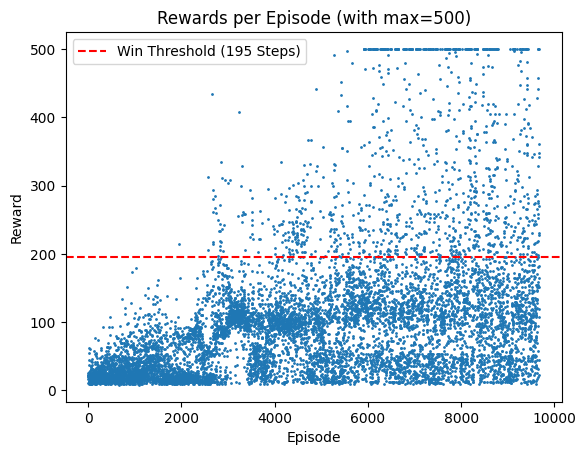

In [13]:
### Plot the episode rewards and training results ###

# Scatter plot of reward for each episode
episodes_completed = len(episode_reward_tracker.episode_rewards)
print(f'Total episodes completed during training = {episodes_completed}')
plt.scatter(range(episodes_completed), episode_reward_tracker.episode_rewards, s=1)
plt.xlabel('Episode')
plt.ylabel('Reward')
# plt.ylim(0, 500)
plt.axhline(y=195, color='r', linestyle='--', label='Win Threshold (195 Steps)')
plt.title('Rewards per Episode (with max=500)')
plt.legend()
plt.show()

In [5]:
### Save the model ###

# Create directory if it DNE yet
save_dir = os.path.join('models')
os.makedirs(save_dir, exist_ok=True)

# Save the model
model_file_name = '6_dqn_stablebaselines3_cartpole.zip'
full_model_path = os.path.join(save_dir, model_file_name)
model.save(full_model_path)
print(f'Model saved to {full_model_path}')

Model saved to models\6_dqn_kerasrl_cartpole.zip


### Model Testing and Utilization
CartPole problem is considered solved once agent wins (stay upright for 195+ steps) for 100 consecutive trials.

In [1]:
### Testing + utilization of the trained policy ###

import os

import gymnasium as gym
import numpy as np
from stable_baselines3 import DQN
from stable_baselines3.common.evaluation import evaluate_policy


# Define trial parameters
NUM_TRIALS = 100
MAX_EPISODE_STEPS = 5000

# Load the saved agent
full_model_path = os.path.join('models', '6_dqn_stablebaselines3_cartpole')
model = DQN.load(full_model_path)

# Test the agent
env = gym.make('CartPole-v1', max_episode_steps=MAX_EPISODE_STEPS)
_, trial_steps = evaluate_policy(model, env, n_eval_episodes=NUM_TRIALS, return_episode_rewards=True)

# Number of wins
trial_steps = np.array(trial_steps)
wins = np.where(trial_steps >= 195, 1, 0)  # 1 for win, 0 for loss
num_wins = np.sum(wins)
trials_terminated_early = np.where(trial_steps == MAX_EPISODE_STEPS, 1, 0)
num_trials_terminated_early = np.sum(trials_terminated_early)
print(f'{len(trial_steps)} trials completed with {num_wins} wins (i.e., >= 195 steps).')

# Other metrics
print(f"Average steps = {(np.mean(trial_steps)):.0f}. Note: {num_trials_terminated_early} trials terminated early at {MAX_EPISODE_STEPS} steps.")
print(f"Median steps = {np.median(trial_steps):.0f}")
print(f"Minimum steps = {np.min(trial_steps)}")
print(f"Maximum steps = {np.max(trial_steps)} (x{num_trials_terminated_early})")

c:\Users\alowe\AppData\Local\Programs\Python\Python312\Lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


100 trials completed with 100 wins (i.e., >= 195 steps).
Average steps = 5000. Note: 100 trials terminated early at 5000 steps.
Median steps = 5000
Minimum steps = 5000
Maximum steps = 5000 (x100)


In [2]:
### Testing to see if agent can hit 1,000,000 steps ###

# Define trial parameters
NUM_TRIALS = 1
MAX_EPISODE_STEPS = 1000000

# Test the agent
env = gym.make('CartPole-v1', max_episode_steps=MAX_EPISODE_STEPS)
_, trial_steps = evaluate_policy(model, env, n_eval_episodes=NUM_TRIALS, return_episode_rewards=True)

# Score
print(trial_steps[0])

c:\Users\alowe\AppData\Local\Programs\Python\Python312\Lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


1000000
